<a href="https://colab.research.google.com/github/YEUNU/class2025spring/blob/main/midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install selenium

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
from tqdm import tqdm

URL = "https://product.kyobobook.co.kr/detail/S000000620181"

options = webdriver.ChromeOptions()
options.add_argument(" --headless")
options.add_argument(" --disable-dev-shm-usage")
options.add_argument(" --no-sandbox")
driver = webdriver.Chrome(options=options)
driver.get(URL)

overlapping_element = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, '#contents > div.prod_detail_footer'))
)
driver.execute_script("arguments[0].remove()", overlapping_element)

html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
last_page = WebDriverWait(driver, 10).until(
    lambda driver: soup.select_one("#ReviewList1 > div.tab_wrap.type_sm > div.tab_content > div > div.pagination > div > a:nth-child(10)")
)
last_page_num = int(last_page.get_text())

reviews = []

for n in tqdm(range(last_page_num - 1)):
    btn_page = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, 'btn_page.next'))
    )
    btn_page.click()
    time.sleep(1)

    comment_texts = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, 'comment_text'))
    )
    for tmp in comment_texts:
        reviews.append(tmp.text)

driver.quit()

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("searle-j/kote_for_easygoing_people")
model = AutoModelForSequenceClassification.from_pretrained("searle-j/kote_for_easygoing_people")

emotion_mapping = {
    0: 'Complaining/Dissatisfaction',
    1: 'Welcome/Favor',
    2: 'Touching/Amazement',
    3: 'Fed Up/Tired of Something',
    4: 'Gratitude',
    5: 'Sadness',
    6: 'Anger/Rage',
    7: 'Respect',
    8: 'Expectation',
    9: 'Arrogance/Disregard',
    10: 'Regret/Disappointment',
    11: 'Solemnity',
    12: 'Doubt/Distrust',
    13: 'Pride',
    14: 'Comfort/Relaxation',
    15: 'Curiosity/Interest',
    16: 'Affection',
    17: 'Shyness',
    18: 'Fear/Terror',
    19: 'Despair',
    20: 'Pitiful/Contempt',
    21: 'Disgust/Revulsion',
    22: 'Annoyance',
    23: 'Absurdity',
    24: 'None',
    25: 'Defeat/Self-Loathing',
    26: 'Annoyed/Lazy',
    27: 'Exhaustion',
    28: 'Excitement/Fun',
    29: 'Realization',
    30: 'Guilt',
    31: 'Hatred',
    32: 'Pleasantness (Cuteness/Beauty)',
    33: 'Embarrassment/Unease',
    34: 'Shock',
    35: 'Burden/Reluctance',
    36: 'Resentment',
    37: 'Boredom',
    38: 'Pity/Compassion',
    39: 'Surprise',
    40: 'Happiness',
    41: 'Anxiety/Worry',
    42: 'Joy',
    43: 'Relief/Trust'
}

results = []
for review in tqdm(reviews):
    inputs = tokenizer(review, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**inputs)
    predicted_class_id = outputs.logits.argmax().item()
    results.append(emotion_mapping[predicted_class_id])


100%|██████████| 75/75 [04:34<00:00,  3.66s/it]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 742/742 [01:28<00:00,  8.40it/s]


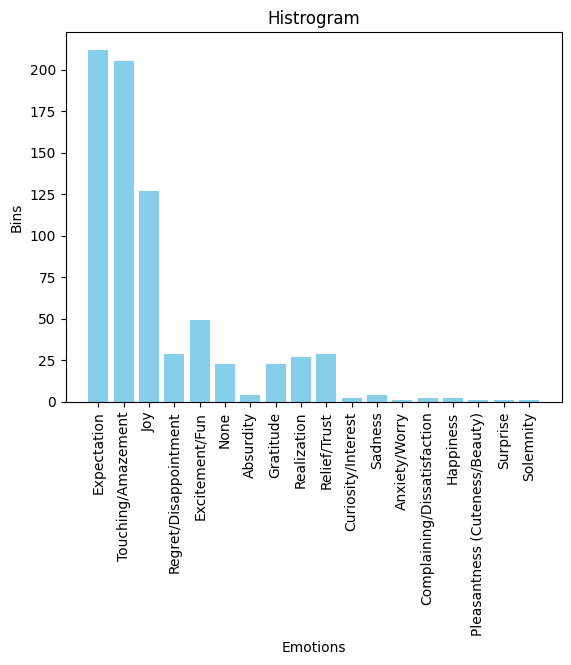

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
emotion_counts = Counter(results)

# 히스토그램 그리기
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Bins')
plt.title('Histrogram')
plt.xticks(rotation=90)
plt.show()
